In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print (device)

cuda


In [1]:
"""
from sklearn.utils.class_weight import compute_class_weight
# Pass a list of unique class labels for 'classes' and the list of all labels in the train set for 'y'
class_weights = compute_class_weight(class_weight="balanced", classes=[0,1,2], y=train_targets)
# Convert the result to a float tensor to make it compatible with the loss function
class_weights = torch.tensor(class_weights),dtype=torch.float).to(device)
# Pass the weights as an argument to your loss function (ex: cross entropy)
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Continue to use your loss function as usual
...
"""

'\nfrom sklearn.utils.class_weight import compute_class_weight\n# Pass a list of unique class labels for \'classes\' and the list of all labels in the train set for \'y\'\nclass_weights = compute_class_weight(class_weight="balanced", classes=[0,1,2], y=train_targets)\n# Convert the result to a float tensor to make it compatible with the loss function\nclass_weights = torch.tensor(class_weights),dtype=torch.float).to(device)\n# Pass the weights as an argument to your loss function (ex: cross entropy)\ncriterion = nn.CrossEntropyLoss(weight=class_weights)\n# Continue to use your loss function as usual\n...\n'

In [4]:
from torch.utils.data import Dataset, random_split
from tqdm import tqdm
from skimage import io
import os

dataset_path = "/kaggle/working/dataset.pt"
raw_data_dir = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/"
"""
def make_weights_for_balanced_classes(images, nclasses):
    n_images = len(images)
    count_per_class = [0] * nclasses
    for _, image_class in images:
        count_per_class[image_class] += 1
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])
    weights = [0] * n_images
    for idx, (image, image_class) in enumerate(images):
        weights[idx] = weight_per_class[image_class]
    return weights
"""
# Define the dataset class
class BreastDataset(Dataset):

    def __init__(self, data_dir, transform=None, target_transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.target_transform = target_transform
        self.load_images(os.path.join(data_dir, "normal"), 0)
        self.load_images(os.path.join(data_dir, "benign"), 1)
        self.load_images(os.path.join(data_dir, "malignant"), 2)

        # Save dataset
        torch.save(self, dataset_path)

    def load_images(self, dir_path, label):
        for filename in tqdm(os.listdir(dir_path)):
            if filename.endswith('.png') and 'mask' not in filename:
                img_path = os.path.join(dir_path, filename)
                img = io.imread(img_path)
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        else:
            return self.images[idx], self.labels[idx]
#Transforms
Transforms = transforms.Compose ([
    transforms.ToPILImage(),
    transforms.Grayscale(1),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
])

dataset = torch.load(dataset_path) if os.path.isfile(dataset_path) else BreastDataset(raw_data_dir, Transforms, Transforms)

# Define the sizes of the training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size


# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

label_names = ['Normal', 'Benign', 'Malignant']

100%|██████████| 421/421 [00:04<00:00, 94.40it/s] 


In [21]:
print(train_dataset[0])

(tensor([[[0.4863, 0.4902, 0.4863,  ..., 0.4431, 0.4431, 0.4392],
         [0.5059, 0.4863, 0.4706,  ..., 0.4667, 0.4745, 0.4824],
         [0.4667, 0.4392, 0.4157,  ..., 0.4549, 0.4549, 0.4745],
         ...,
         [0.4157, 0.3922, 0.3765,  ..., 0.0745, 0.0863, 0.1137],
         [0.4196, 0.4039, 0.3922,  ..., 0.0980, 0.1176, 0.1490],
         [0.3529, 0.3333, 0.3216,  ..., 0.1529, 0.1765, 0.2196]]]), 1)


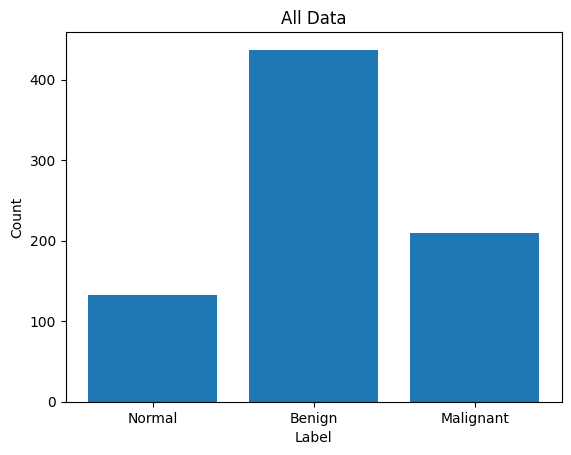

{'Normal': 133, 'Benign': 437, 'Malignant': 210}





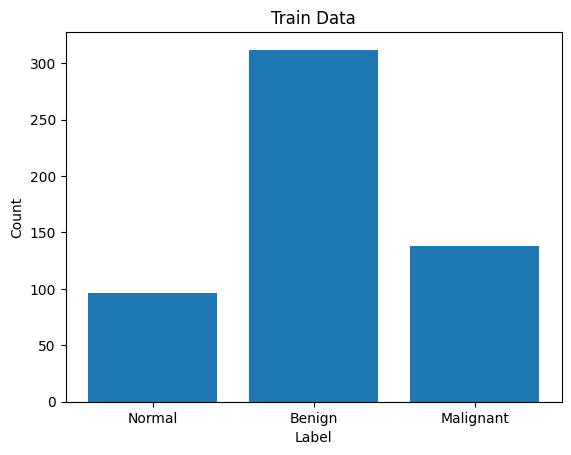

{'Normal': 96, 'Benign': 312, 'Malignant': 138}





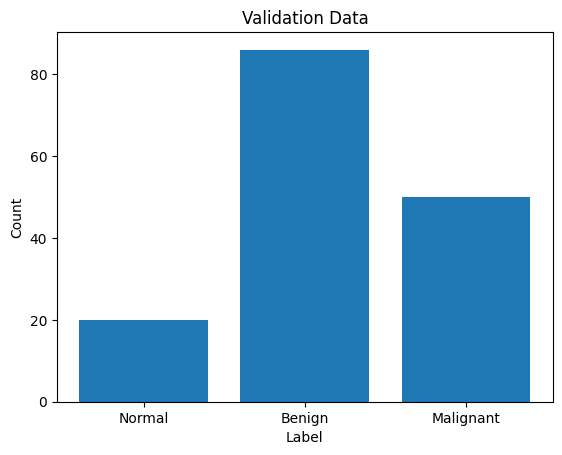

{'Normal': 20, 'Benign': 86, 'Malignant': 50}





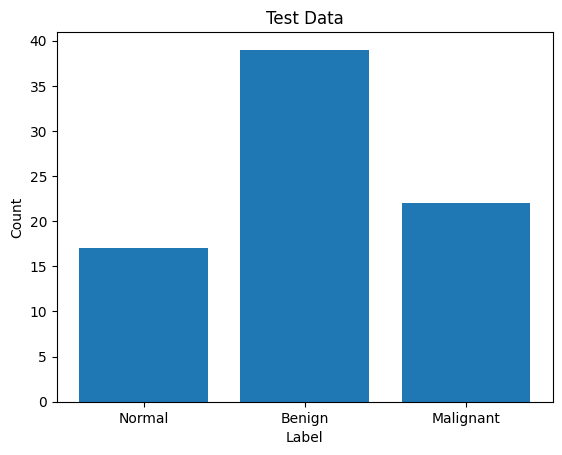

{'Normal': 17, 'Benign': 39, 'Malignant': 22}



torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])
torch.Size([1, 300, 300])


In [5]:
def data_stats(data, title):
    label_counts = {}
    for label_name in label_names:
        label_counts[label_name] = 0

    for i in range(len(data)):
        _, lbl = data[i]
        label_name = label_names[lbl]
        label_counts[label_name] += 1

    # Extract the counts and labels as separate lists
    counts = list(label_counts.values())
    labels = list(label_counts.keys())

    # Create a bar chart using matplotlib
    plt.bar(labels, counts)

    # Add axis labels and a title
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(title)

    # Display the chart
    plt.show()
    print(label_counts)
    print('\n\n')

data_stats(dataset, 'All Data')
data_stats(train_dataset, 'Train Data')
data_stats(val_dataset, 'Validation Data')
data_stats(test_dataset, 'Test Data')
for i in range(10):
    image = train_dataset[i][0]
    print(image.shape)


In [9]:
#Hyperparameters
BATCH_SIZE = 5
SHUFFLE = True



#DataLoaders

# For unbalanced dataset we create a weighted sampler                       
"""
weights = make_weights_for_balanced_classes(dataset.images, len(dataset.labels))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle = True,                              
                                                             sampler = sampler, num_workers=args.workers, pin_memory=True)  
"""
train_loader = DataLoader(train_dataset, BATCH_SIZE, SHUFFLE)
test_loader = DataLoader(test_dataset, BATCH_SIZE, SHUFFLE)
val_loader = DataLoader(val_dataset, BATCH_SIZE, SHUFFLE)
to_onehot = nn.Embedding(3, 3)
to_onehot.weight.data = torch.eye(3)


ValueError: too many values to unpack (expected 2)

In [19]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, best_loss):
    validation_loss = []
    training_loss = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range (num_epochs):
        batch_nr = 0
        for batch_nr, (images, labels) in enumerate (train_loader):
            images = images.to(device)
            labels = to_onehot(labels)
            labels = labels.to(device)
            #targets = F.one_hot(labels, 3)
            prediction = F.softmax(model(images))
            loss = criterion (prediction, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss} Best Val-Loss: {best_loss}',end='')

        best_loss = validation_model(best_loss, model, criterion, val_loader, validation_loss)
        training_loss.append(float(loss))
    plt.figure(figsize=(10,5))
    plt.plot(training_loss, label = "training loss")
    plt.plot(validation_loss, label = "validation loss")
    plt.legend()
    plt.show()
    
    model = torch.load("best_network.pt")
    return model

def validation_model(best_loss, model, criterion, validation_loader, validation_loss):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)
    for nr,(images, labels) in enumerate(validation_loader):
        images = images.to(device)
        labels = to_onehot(labels)
        labels = labels.to(device)
        #targets = to_onehot(labels)
        prediction = F.softmax(model(images))
        val_loss = criterion(prediction, labels)

        if best_loss > val_loss:
            best_loss = val_loss
            torch.save(model, "best_network.pt")
    validation_loss.append(val_loss.item())
    return  best_loss

def test_model(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    pred = []
    pred_labels = []
    target = []
    correct_predictions = 0
    total_predictions = 0
    
    for batch_nr, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        #targets = to_onehot (labels)
        prediction = F.softmax(model(images))
        pred.append(prediction)
        target.append(labels)
        """for index in range(len(prediction)):
            pred.append(torch.argmax(prediction[index]).item())
            target.append(torch.argmax(labels[index]).item())"""
        predicted_labels = torch.argmax(prediction, dim=1)
        pred_labels.append(predicted_labels)
        # Calculate the number of correct predictions in this batch
        batch_correct_predictions = (predicted_labels == labels).sum().item()

        # Update the total number of correct predictions and total number of predictions
        correct_predictions += batch_correct_predictions
        total_predictions += labels.size(0)
    return (100*(correct_predictions / total_predictions)), pred_labels, target


/tmp/ipykernel_32/1929615113.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = F.softmax(model(images))


Epoch 1 [110/110] - Loss: 0.5514447689056396 Best Val-Loss: 100

/tmp/ipykernel_32/1929615113.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = F.softmax(model(images))


Epoch 7 [110/110] - Loss: 0.5516369342803955 Best Val-Loss: 0.5514447689056396

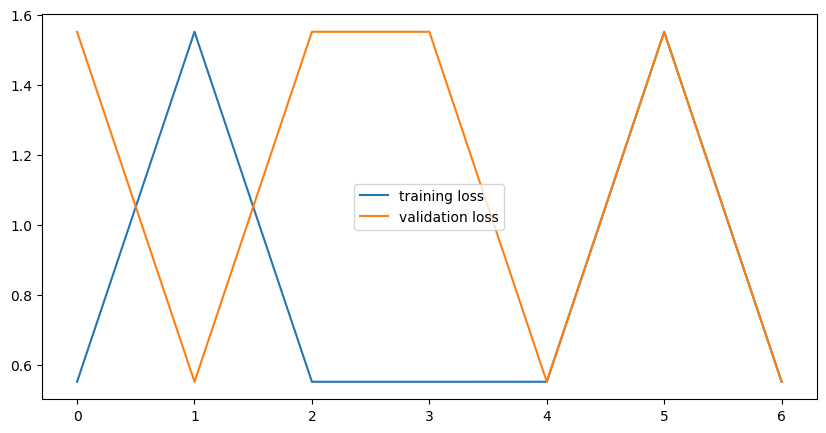

In [20]:
LEARNING_RATE = 0.025
epochs = 7

# Fine-tune a model to the dataset
# We use resnet18 as the model.
model_ft = models.resnet18(pretrained=True)
model_ft.conv1 = nn.Conv2d(1, 64, 2)
#with this code we just reset the last fully connected layer
num_fts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fts, 3)
# Do the things required for fine-tuning before training the model

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr = LEARNING_RATE, weight_decay=1e-4) # L2 regularization

# Train the model
trained_model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, val_loader, epochs, 100)



/tmp/ipykernel_32/1929615113.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = F.softmax(model(images))


Accuracy:  53 %


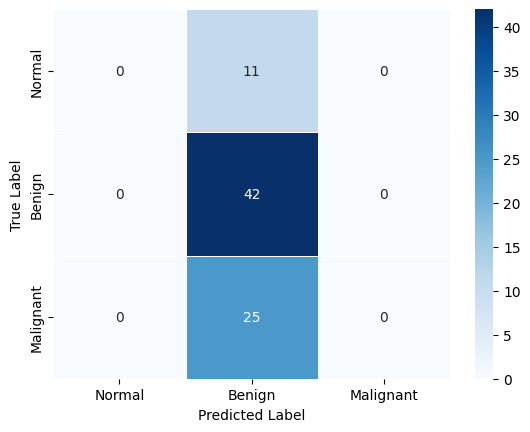

In [21]:
# Test the model
tested_model = test_model(trained_model_ft, test_loader)
predicted = tested_model[1]
real = tested_model[2]

def flatten(l):
    return [item for sublist in l for item in sublist]

real_working = []
for i in real:
    real_working.append(i.cpu().numpy())

predicted_working = []
for i in predicted:
    predicted_working.append(i.cpu().numpy())

conf_matrix = confusion_matrix(flatten(real_working), flatten(predicted_working))
categories = ['Normal', 'Benign', 'Malignant']
xlabel = 'Predicted Label'
ylabel = 'True Label'

ax = sns.heatmap(conf_matrix, annot=True, linewidth=.5, cmap='Blues', xticklabels=categories, yticklabels=categories)

# Add the x and y axis labels
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

print("Accuracy: ", int(tested_model[0]), "%")